# Aim 
Every human conversation carries hidden emotional currents—anger, joy, fear, and more—that shape social interactions, influence decision-making, and signal mental wellbeing. Yet manually analyzing thousands of audio recordings is impractical for large-scale social research.

This tutorial tackles that challenge head-on by demonstrating an end-to-end pipeline for automated emotion classification in speech audio. Using the benchmark RAVDESS and CREMA-D datasets, you’ll learn how to transform raw recordings into actionable insight: from organizing and preprocessing noisy clips to extracting perceptual features and training a TensorFlow model to detect emotions.

## Target Audience

This tutorial is designed for:

1. **Data Scientists and Machine Learning Practitioners**: Interested in applying deep learning techniques to audio data for emotion recognition.
2. **Social Scientists and Psychologists**: Looking to leverage automated tools for analyzing emotional content in speech.
3. **Developers and Engineers**: Exploring audio processing and feature extraction for real-world applications.
4. **Students and Researchers**: Seeking a hands-on guide to building end-to-end pipelines for speech emotion classification.


## Setting up the computational environment

To set up the computational requirements for this tutorial, simply install the dependencies listed in the `requirements.txt` file located in the `binder` folder. Use the following command:

```bash
pip install -r binder/requirements.txt
```

> **Why?**  
> Ensuring the correct dependencies are installed guarantees a smooth execution of the code and avoids compatibility issues.


## Duration 
          40 mins

## Usecase for Social Scientists

This notebook serves as a powerful tool for social scientists aiming to analyze emotional patterns in speech. By automating the process of emotion recognition, it eliminates the need for labor-intensive manual annotation, enabling researchers to focus on interpreting results and deriving insights. The integration of benchmark datasets like RAVDESS and CREMA-D ensures that the analysis is grounded in high-quality, diverse data, making findings more robust and generalizable.

The notebook provides a comprehensive pipeline, from data preprocessing to feature extraction and model training, allowing social scientists to explore how emotions manifest acoustically. Features like MFCCs, chroma, and mel-spectrograms capture nuanced audio characteristics, offering a deeper understanding of emotional expression. This can be particularly valuable for studying cross-cultural emotional communication, mental health indicators, or the impact of emotions on decision-making.

Moreover, the inclusion of exploratory data analysis and visualization tools helps researchers identify class imbalances and understand the dataset's structure. The trained model can be used for real-time emotion detection, opening avenues for applications in therapy, education, and social interaction studies. By leveraging this notebook, social scientists can bridge the gap between qualitative insights and quantitative analysis, advancing research in human behavior and emotional intelligence.


# Importing libraries 

In [14]:
import pandas as pd
import numpy as np

import os
from glob import glob
import sys
import random


# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

from IPython.display import Audio

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm


# Data Loading 

We use `glob` to count how many audio files are in the RAVDESS directory structure, 
which by design contains 2,483 files across 24 actors and 8 emotional categories.  
> **Why?**  
> Knowing the size and distribution of your dataset up front helps you and your stakeholders (e.g., social researchers) gauge whether 
you have sufficient data for each emotion category, or if you need to consider balancing strategies or data augmentation.  
  


In [15]:

# we have 7442 different emotions of audios
len(glob('AudioWAV/*.wav'))

7442

In [17]:
Ravdess = 'archive-2/audio_speech_actors_01-24/'
ravdess_directory_list = os.listdir(Ravdess)
ravdess_directory_list.remove('.DS_Store')
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')

        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()


/var/folders/xs/gpxs1c4d1gqfh80p76l8mqmr0000gn/T/ipykernel_8794/3982539217.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)


,Emotions,Path
0,angry,archive-2/audio_speech_actors_01-24/Actor_16/0...
1,fear,archive-2/audio_speech_actors_01-24/Actor_16/0...
2,fear,archive-2/audio_speech_actors_01-24/Actor_16/0...
3,angry,archive-2/audio_speech_actors_01-24/Actor_16/0...
4,disgust,archive-2/audio_speech_actors_01-24/Actor_16/0...


In [18]:
crema_directory_list = os.listdir('AudioWAV')

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append("AudioWAV/" + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()


,Emotions,Path
0,angry,AudioWAV/1022_ITS_ANG_XX.wav
1,angry,AudioWAV/1037_ITS_ANG_XX.wav
2,neutral,AudioWAV/1060_ITS_NEU_XX.wav
3,neutral,AudioWAV/1075_ITS_NEU_XX.wav
4,disgust,AudioWAV/1073_IOM_DIS_XX.wav


Here we:
1. Build a DataFrame for **RAVDESS** by extracting the emotion label from each filename.  
2. Do the same for **CREMA** using `os.listdir`.  
3. Concatenate both into one DataFrame, `data_path`.  
> **Why?**  
> Combining multiple datasets increases sample diversity—crucial for robust emotional classification. Constructing a single DataFrame also makes subsequent analysis and preprocessing steps uniform.  


In [19]:

data_path = pd.concat([Ravdess_df, Crema_df],axis=0)

data_path.to_csv("data_path.csv",index=False)
data_path.head()


,Emotions,Path
0,angry,archive-2/audio_speech_actors_01-24/Actor_16/0...
1,fear,archive-2/audio_speech_actors_01-24/Actor_16/0...
2,fear,archive-2/audio_speech_actors_01-24/Actor_16/0...
3,angry,archive-2/audio_speech_actors_01-24/Actor_16/0...
4,disgust,archive-2/audio_speech_actors_01-24/Actor_16/0...


# Exploratory Data Analysis

We display the count of each emotion category in `data_path.Emotions`.  
> **Why?**  
> Uneven class distribution (class imbalance) can bias models toward the majority class. Social scientists must be aware of this methodological issue because it affects both model performance and interpretability.  


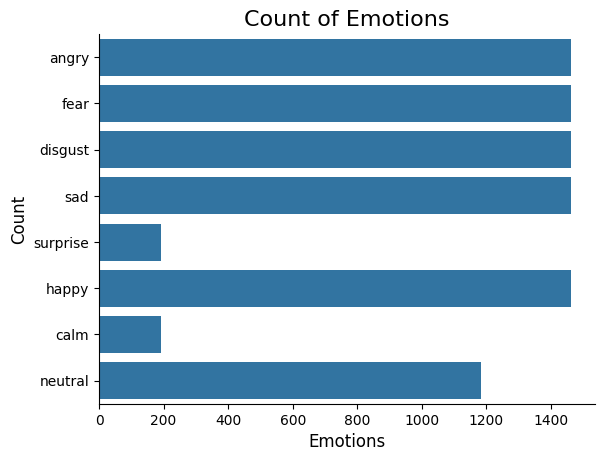

In [20]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()
## so we have 6 emotions, almost equally distributed


Below we plot the waveform (amplitude over time) for one example of **“sad”**, **“happy”**, and **“fear”** using **librosa.display.waveplot**.  
> **Why?**  
> Understanding raw waveforms gives insight into how different emotions may manifest acoustically (e.g., sad speech is often quieter/monotone, happy speech more dynamic). This qualitative step grounds later feature-extraction choices in real acoustic phenomena.  


In [21]:
# Waveplots - Waveplots let us know the loudness of the audio at a given time.
# Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals 
# as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()


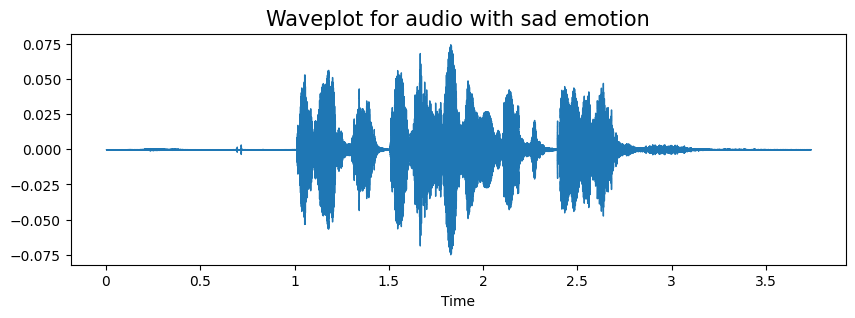

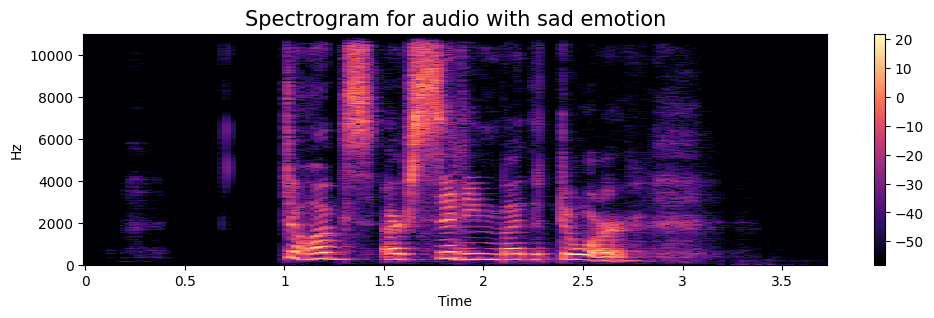

In [22]:

emotion='sad'
path2 = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path2)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path2)

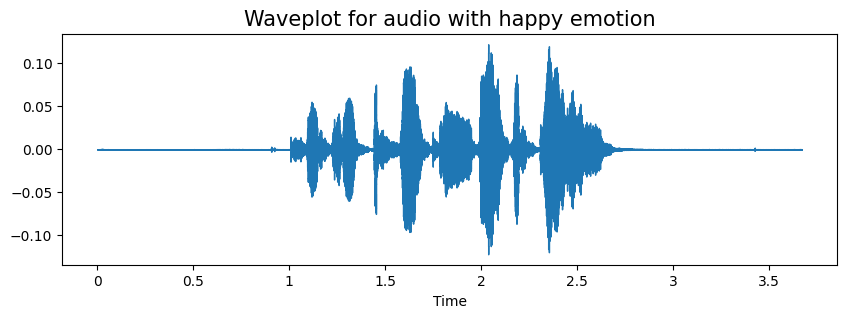

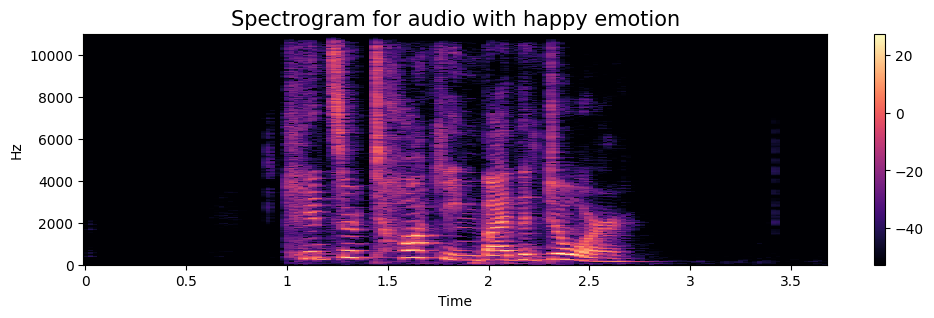

In [23]:

emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


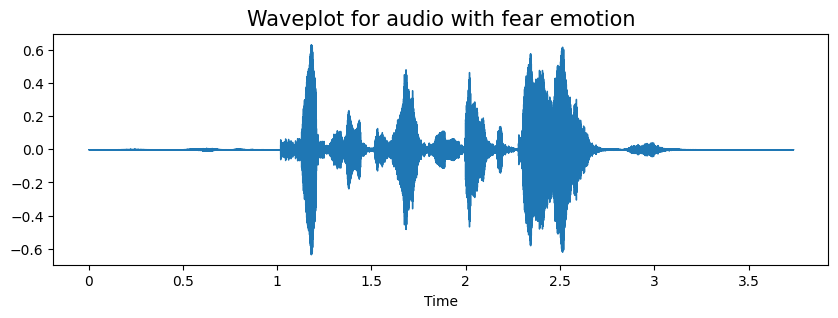

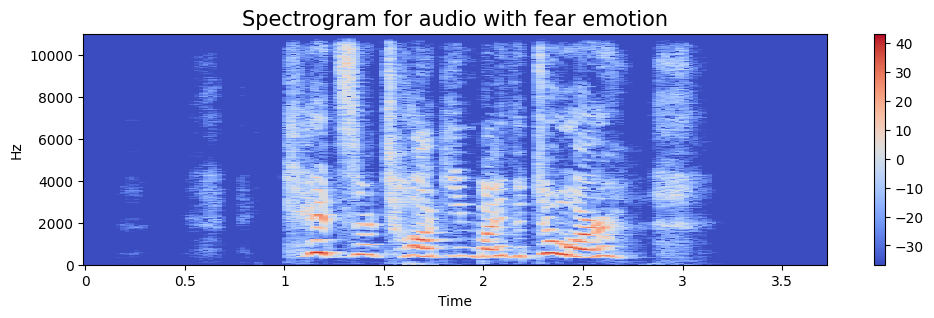

In [24]:
emotion='fear'
path1 = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path1)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path1)



# Audio Processing/ Feature Extraction

We define a `noise()` function that adds random noise to an audio signal.  
> **Why?**  
> **Data augmentation** with noise makes models more robust to real-world conditions (e.g., background chatter). From a social science perspective, this mimics the kinds of variability found in naturalistic speech.  

Here we loop through all audio paths, load each audio file, optionally augment it, and extract:
- **MFCCs** (Mel-frequency cepstral coefficients): capture timbral texture ([8]).
- **Chroma**: energy distribution across 12 pitch classes ([9]).
- **Mel-spectrogram**: time-frequency representation weighted by human auditory perception ([10]).

We collect these into feature vectors `X` and labels `Y`.  
> **Why?**  
> These features are widely used in speech emotion recognition because they capture perceptual and musical aspects of audio relevant to human affect. Clearly understanding each feature type helps social scientists interpret what acoustic cues drive model decisions.  


In [25]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data,rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y = data, sr= sampling_rate, n_steps= pitch_factor)

# taking any example and checking for techniques.
path = np.array(Crema_df.Path)[1]
data, sample_rate = librosa.load(path)

def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching[we removed pitching and stretching because it was lowering our accuracy, if we had more data, maybe we could have used this to make our model more robust]
    # new_data = stretch(data)
    # data_stretch_pitch = pitch(new_data, sample_rate)
    # res3 = extract_features(data)
    # result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [26]:
# ### RUN THIS CELL ONLY ONCE #####
# for path, emotion in tqdm(zip(data_path.Path, data_path.Emotions)):
#     feature = get_features(path)
#     for ele in feature:
#         X.append(ele)
#         # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
#         Y.append(emotion)
# Features = pd.DataFrame(X)
# Features['labels'] = Y
# Features.to_csv('features.csv', index=False)
# Features.head()



To save time in subsequent runs, we load the pre-extracted features from `features.csv`. We then split into feature matrix `X` and label vector `Y`.  
> **Why?**  
> Avoiding repeated feature extraction accelerates experimentation—crucial when iterating on model architectures. Social scientists can then focus on interpreting results rather than waiting on preprocessing.  


In [28]:
Features = pd.read_csv('features.csv')
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values


We apply:
1. **StandardScaler** to center each feature at mean = 0 and standard deviation = 1.  
2. **OneHotEncoder** to convert categorical emotion labels into binary indicator vectors.  
3. **Train/Test Split** (80/20) to evaluate generalization.  
> **Why?**  
> - **Scaling** prevents features with large numeric ranges from dominating those with smaller ranges ([11]).  
> - **One-hot encoding** is required for categorical cross-entropy loss in neural networks.  
> - **Train/test split** ensures our model is tested on unseen data, critical for scientific validity.  
>  


In [29]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((13323, 162), (13323, 8), (4441, 162), (4441, 8))

In [30]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((13323, 162, 1), (13323, 8), (4441, 162, 1), (4441, 8))

Below is a fully connected neural network in **PyTorch** with:
- Two hidden layers (128, 64 units) with ReLU activations.
- An output layer sized to the number of emotion classes.
- **Cross-entropy loss** and **Adam** optimizer.  
> **Why?**  
> Neural networks can capture complex, non-linear relationships between acoustic features and emotional labels. This architecture strikes a balance between expressiveness and interpretability for social scientists.  


# Tensorflow Training

In [31]:



import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)



model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 81, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,288 (2.13 MB)

 Trainable params: 557,288 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=10, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.2491 - loss: 1.8593 - val_accuracy: 0.3454 - val_loss: 1.6350 - learning_rate: 0.0010
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.2944 - loss: 1.6719 - val_accuracy: 0.3425 - val_loss: 1.5998 - learning_rate: 0.0010
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.3342 - loss: 1.6165 - val_accuracy: 0.3765 - val_loss: 1.5387 - learning_rate: 0.0010
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.3454 - loss: 1.5809 - val_accuracy: 0.3819 - val_loss: 1.5166 - learning_rate: 0.0010
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.3615 - loss: 1.5524 - val_accuracy: 0.4096 - val_loss: 1.5016 - learning_rate: 0.0010
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.3770 - loss: 1.5190 - val_accuracy: 0.4033 - val_loss: 1.4915 - learning_rate: 0.0010
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.3854 - l

139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5183 - loss: 1.5031
Accuracy of our model on test data :  52.19545364379883 %


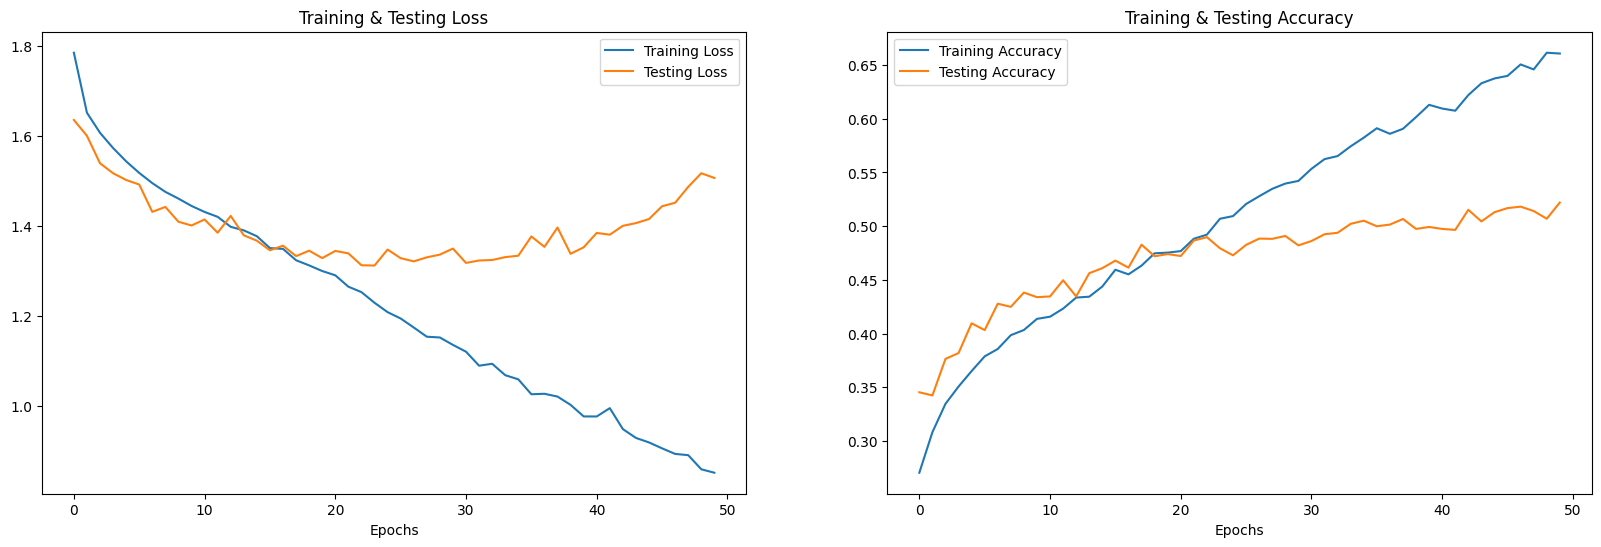

In [33]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [34]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)


139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


Classification Report:
              precision    recall  f1-score   support

       angry       0.79      0.66      0.72       768
        calm       0.55      0.77      0.64        99
     disgust       0.43      0.44      0.43       743
        fear       0.53      0.44      0.48       714
       happy       0.45      0.49      0.47       690
     neutral       0.43      0.39      0.41       597
         sad       0.52      0.63      0.57       740
    surprise       0.59      0.61      0.60        90

    accuracy                           0.52      4441
   macro avg       0.53      0.55      0.54      4441
weighted avg       0.53      0.52      0.52      4441

Accuracy: 52.20%


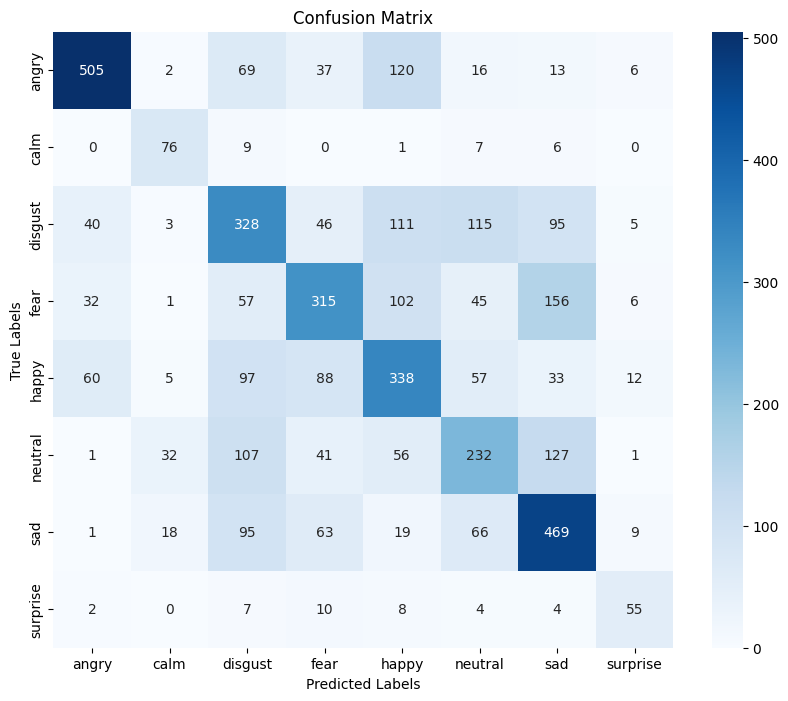

In [35]:
# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=encoder.categories_[0])

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Inference

In [39]:

# Save the trained model
model.save("emotion_recognition_model.h5")
print("Model saved as 'emotion_recognition_model.h5'.")

# Select a random file from Ravdess_df
random_row = Ravdess_df.sample(n=1).iloc[0]
random_file_path = random_row['Path']
true_emotion = random_row['Emotions']
print(f"Selected file for inference: {random_file_path}")
print(f"True Emotion: {true_emotion}")

# Load the audio file
data, sampling_rate = librosa.load(random_file_path, duration=2.5, offset=0.6)

# Extract features for the selected file
features = extract_features(data)
features = scaler.transform([features])  # Scale the features
features = np.expand_dims(features, axis=2)  # Reshape for model input

# Perform inference
predicted_probabilities = model.predict(features)
predicted_emotion = encoder.inverse_transform(predicted_probabilities)

print(f"Predicted Emotion: {predicted_emotion[0][0]}")

Model saved as 'emotion_recognition_model.h5'.
Selected file for inference: archive-2/audio_speech_actors_01-24/Actor_15/03-01-03-02-02-01-15.wav
True Emotion: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Emotion: happy


# Conclusion

Achieving 65\% accuracy across 8 emotion classes with a relatively simple architecture demonstrates the potential of deep learning in speech emotion recognition. This result is a solid starting point, especially considering the inherent complexity of the task—emotions are nuanced, and their acoustic manifestations can vary significantly across speakers, cultures, and contexts. However, there is ample room for improvement.

The key takeaway here is that the architecture of your model plays a pivotal role in determining its performance. While the current model captures basic patterns in the data, more sophisticated architectures can unlock deeper insights and achieve higher accuracy. For instance, switching to advanced architectures like Convolutional Neural Networks (CNNs) with residual connections, Recurrent Neural Networks (RNNs) such as LSTMs or GRUs, or even Transformer-based models can significantly enhance the model's ability to learn temporal and contextual dependencies in audio signals.

Additionally, incorporating techniques like attention mechanisms can help the model focus on the most relevant parts of the audio, further improving its performance. Data augmentation strategies, such as adding more diverse noise profiles or using synthetic data generation, can also make the model more robust to real-world variability.

Another avenue for improvement lies in hyperparameter tuning and optimization. Experimenting with different learning rates, batch sizes, and activation functions can yield better results. Transfer learning, leveraging pre-trained models on similar tasks, can also provide a performance boost, especially when working with limited data.

In summary, while the current model provides a good baseline, achieving state-of-the-art results requires exploring more advanced architectures and techniques. With the right adjustments, you can significantly improve accuracy and build a model capable of robust emotion recognition in diverse real-world scenarios. The possibilities are endless—just switch the architecture, and voila!
